<a href="https://colab.research.google.com/github/wallisonferreira/data-science-tce/blob/main/2_Dados_Desbalanceados_p1_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exemplo com dados desbalanceados

Agenda:
- lidar com o peso no loss (class_weight)
- utilizar as bibliotecas para aprendizado de máquina
- limpeza e tratamento de dados, com dataset estruturado
- criar um modelo MLP
- realizar experimentos
- realizar análise de resultados
- refatorar código para que seja reutilizável

Libs que usaremos:
- Tensorflow
- Keras
- Sklearn
- Numpy
- Pandas




In [1]:
!pip install livelossplot
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.5 MB/s eta 0:00:00


In [2]:
#keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

#utilitários
import pandas as pd
import numpy as np
import random
import seaborn as sns
from livelossplot import PlotLossesKeras

#sklearn
import sklearn as sk
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score

#balanceamento
from imblearn.combine import SMOTEENN

#explicabilidade
import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#Etapa 1: Dataset
- Aquisição
- Análise inicial
- Preparação

Neste exemplo, utilizaremos o dataset Credict Card Fraud ( [leia mais aqui](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)).

*Link com o dataset: https://drive.google.com/file/d/1YpVIk0wSo_QuuW-KOSEXI8XoKl4jUizt/view?usp=sharing

**Você pode baixar direto do Kaggle:

```
!pip install kaggle
import os
os.environ['KAGGLE_USERNAME'] = "SEU USUARIO"
os.environ['KAGGLE_KEY'] = "CHAVE DA API -- Não é senha"
!kaggle datasets download -d mlg-ulb/creditcardfraud/
!unzip /content/creditcardfraud.zip
```

Ou carregue os dados para o drive, e monte o drive.

```
from google.colab import drive
drive.mount('/content/drive')
```


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
!cp /content/drive/MyDrive/'2. TCE data'/creditcard.csv .


In [32]:
dataframe.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log_Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.248367


[284315    492]


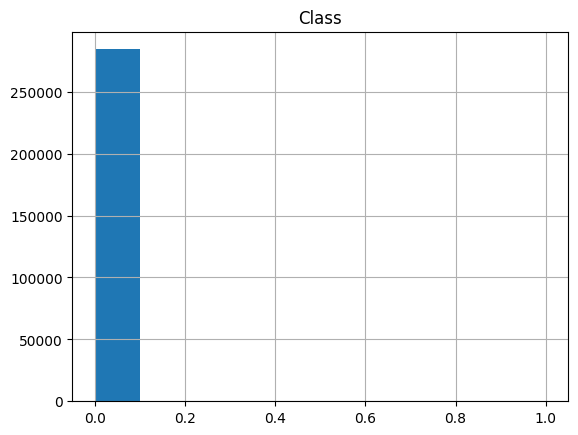

In [33]:
dataframe = pd.read_csv('creditcard.csv')
dataframe.hist(column = 'Class')
contagem = np.bincount(dataframe['Class'])
print(contagem)

In [16]:
dataframe.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [34]:
dataframe = dataframe.drop(columns = ['Time'])
dataframe.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##### Como os dados tão muito próximo de zero, fazer uma separação logaritmica para dar importância aos poucos maiores e irem a 1.

In [35]:
dataframe['Log_Ammount'] = np.log(dataframe['Amount']+0.001)
dataframe.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Log_Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.248367


In [36]:
dataframe.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Log_Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.248367


##### Atribui o class ao y

In [37]:
from tensorflow.keras.utils import to_categorical

#obter o target
y = dataframe['Class']
y = y.to_numpy()

#formato desejado
'''
Quando binário
[0, 1, 1, 0, ....]


Quando categórico
[
  [1 , 0]
  [0 , 1]
  ...
]

dataframe = dataframe.drop(columns=['target'])
y = to_categorical(y, num_classes=2) #para converter no formato one hot

'''
y

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
dataframe = dataframe.drop(columns=['Amount', 'Class'])
X = normalize(dataframe.to_numpy(), axis = 0)
X

array([[-1.30087556e-03, -8.25878667e-05,  3.13445335e-03, ...,
         6.20026772e-04, -1.19513515e-04,  2.62798601e-03],
       [ 1.14020419e-03,  3.02012437e-04,  2.05738490e-04, ...,
        -4.17028277e-05,  8.35858430e-05,  5.19453357e-04],
       [-1.29948546e-03, -1.52073956e-03,  2.19135731e-03, ...,
        -2.56967890e-04, -3.39197947e-04,  3.11523202e-03],
       ...,
       [ 1.83637455e-03, -3.41845444e-04, -4.01595107e-03, ...,
         2.06806795e-05, -1.50779933e-04,  2.21325297e-03],
       [-2.30019815e-04,  6.01960879e-04,  8.68172126e-04, ...,
         5.05185602e-04,  5.93409644e-04,  1.20832604e-03],
       [-5.10295392e-04, -2.15298419e-04,  8.69194314e-04, ...,
        -1.12127457e-05,  7.74818596e-05,  2.82308495e-03]])

#Etapa 2: Montar o modelo

In [39]:
def construirModelo(input_shape):
  model = keras.Sequential(
      [layers.Input(shape= input_shape),
       layers.Dense(256, activation='relu'),
       layers.Dense(256, activation='relu'),
       #sigmoid = valor entre 0 e 1 --> squash -->
       #mais próx de 0 = classe 0
       #mais próx de 1 = classe 1
       layers.Dense(1, activation='sigmoid')
      ]
  )

  #especificar: otimizador e função de custo
  model.compile("adam", "binary_crossentropy",
                metrics=[
                    keras.metrics.BinaryAccuracy(name='accuracy')],
                )
  return model

model = construirModelo(X.shape[1])
#plot_model(model, show_shapes=True)


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7680      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 73729 (288.00 KB)
Trainable params: 73729 (288.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#Etapa 3: Experimento -- com Hold-Out

Neste primeiro treinamento, vamos avaliar sem considerar o desbalanceamento do dataset

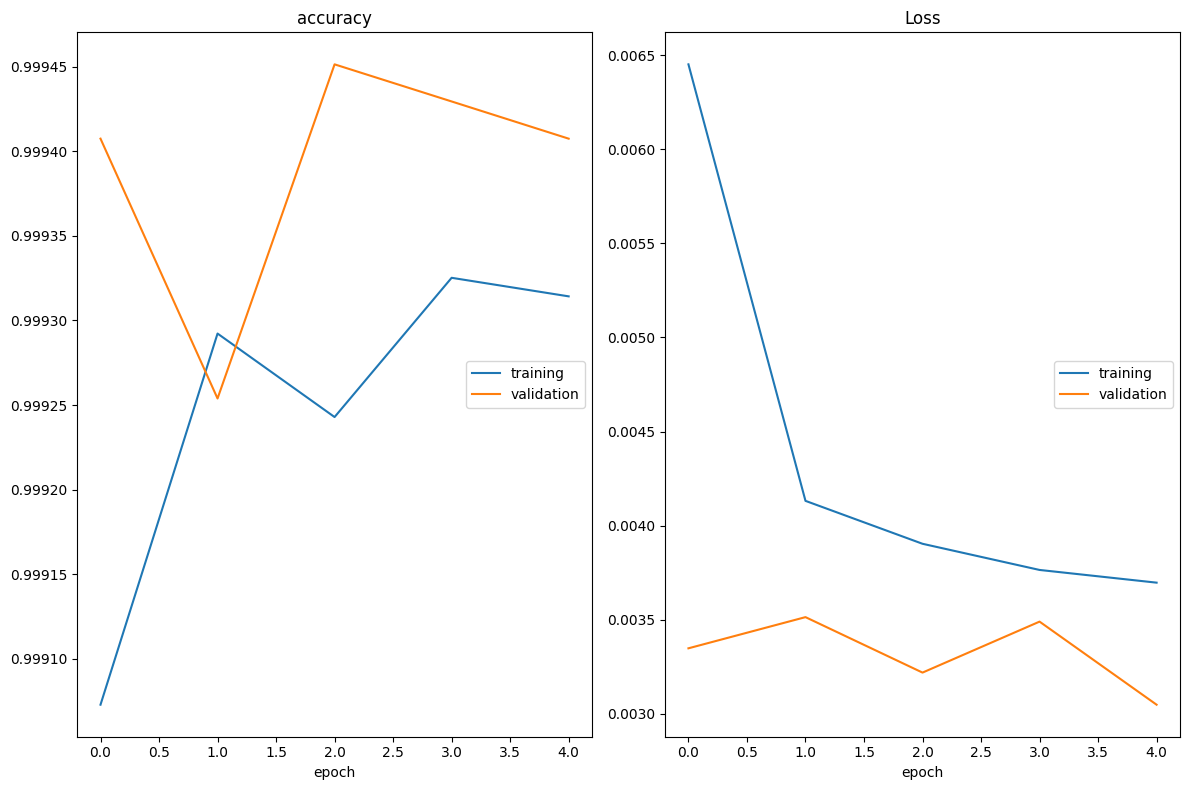

accuracy
	training         	 (min:    0.999, max:    0.999, cur:    0.999)
	validation       	 (min:    0.999, max:    0.999, cur:    0.999)
Loss
	training         	 (min:    0.004, max:    0.006, cur:    0.004)
	validation       	 (min:    0.003, max:    0.004, cur:    0.003)
1781/1781 [==============================] - 4s 2ms/step
Matriz interação 0:
Recall: 0.8404255319148937 +- 0.0
Precisão: 0.8876404494382022 +- 0.0
F1: 0.8633879781420766 +- 0.0


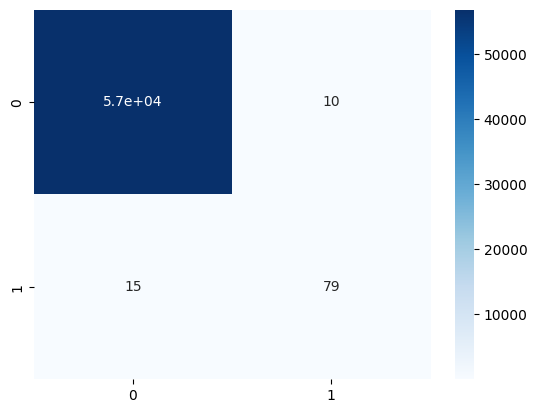

In [41]:
n_runs = 1 #número de execuções
perc_treino = 0.8
batch_size = 16
epochs = 5

recall = []
prec = []
f1 = []

for i in range(n_runs):

  #pre-requisito
  model = construirModelo(X.shape[1])

  #a) divide a base aleatoriamente
  x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=perc_treino,
                                                      random_state = random.randint(1, 1000))
  #b) treina
  H = model.fit(
      x_train,
      y_train,
      batch_size= batch_size,
      epochs = epochs,
      callbacks=[PlotLossesKeras()], #plotando gráficos
      validation_split = 0.2)

  #c) predição
  y_pred = model.predict(x_test)
  y_true = y_test

  #TODO ajuste o valor de corte adequadamento
  y_pred [y_pred >= 0.5] = 1
  y_pred [y_pred < 0.5]  = 0

  #d) acumula resultados
  recall.append(recall_score(y_true, y_pred, average='binary', pos_label=1))
  prec.append(precision_score(y_true, y_pred, average='binary', pos_label=1))
  f1.append(f1_score(y_true, y_pred, average='binary', pos_label=1))

  matrix = confusion_matrix(y_true, y_pred)
  print("Matriz interação " + str(i) + ":")
  sns.heatmap(matrix, cmap='Blues', annot=True)


#calculando as médias das execuções
recall_media = np.asarray(recall).mean(axis=0)
prec_media = np.asarray(prec).mean(axis=0)
f1_media = np.asarray(f1).mean(axis=0)

#calculando os desvios das execuções
recall_std = np.asarray(recall).std(axis=0)
prec_std = np.asarray(prec).std(axis=0)
f1_std = np.asarray(f1).std(axis=0)

print ("Recall: " + str(recall_media) + " +- " + str(recall_std))
print ("Precisão: " + str(prec_media) + " +- " + str(prec_std))
print ("F1: " + str(f1_media) + " +- " + str(f1_std))



##a) Considerando o desbalanceamento - Mudando o loss

Usando o class_weight
Cria-se um vetor com a desproporcionalidade, e adiciona no fit.

O erro em classe minoritárias começa a custar mais caro

```
#ponderação por classe
contagem = np.bincount(y)
class_weight = {0: (1/contagem[0]), 1: (1/contagem[1])}
print(class_weight)
```


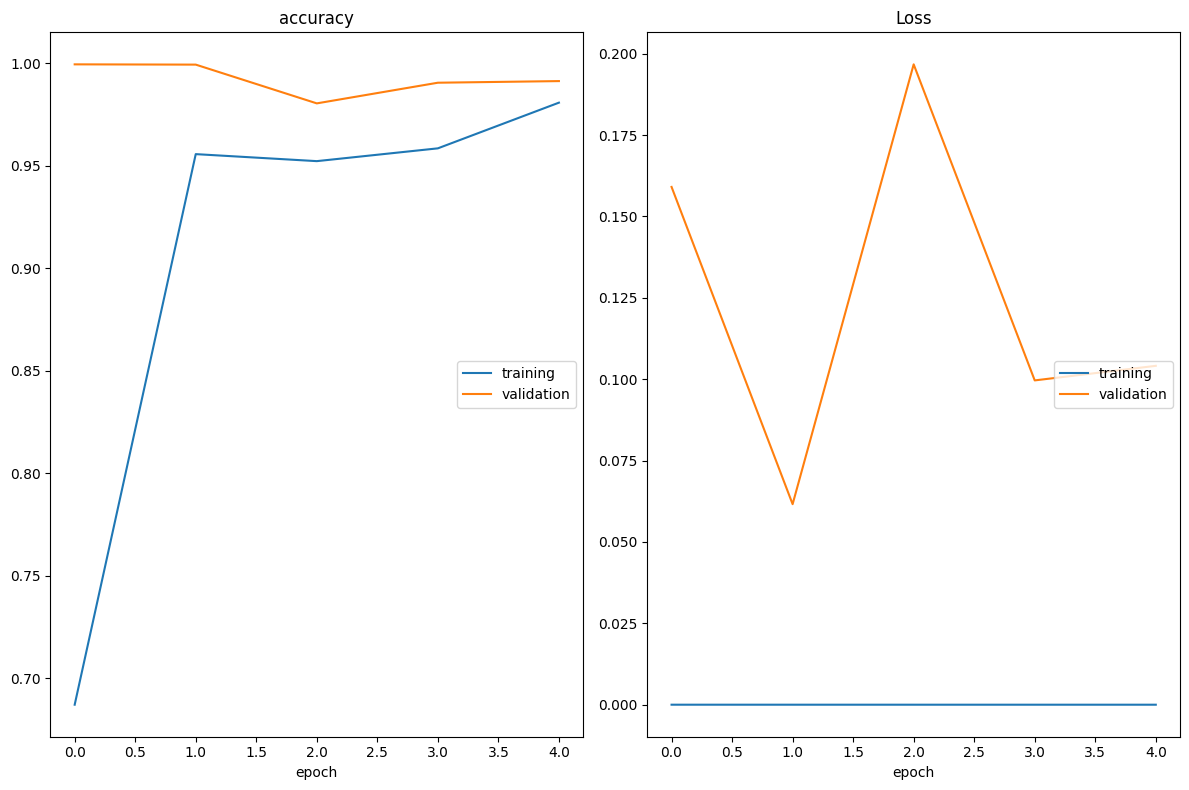

accuracy
	training         	 (min:    0.687, max:    0.981, cur:    0.981)
	validation       	 (min:    0.980, max:    0.999, cur:    0.991)
Loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.062, max:    0.197, cur:    0.104)
1781/1781 [==============================] - 3s 2ms/step
Matriz interação 0:
Recall: 0.883495145631068 +- 0.0
Precisão: 0.15294117647058825 +- 0.0
F1: 0.26074498567335247 +- 0.0


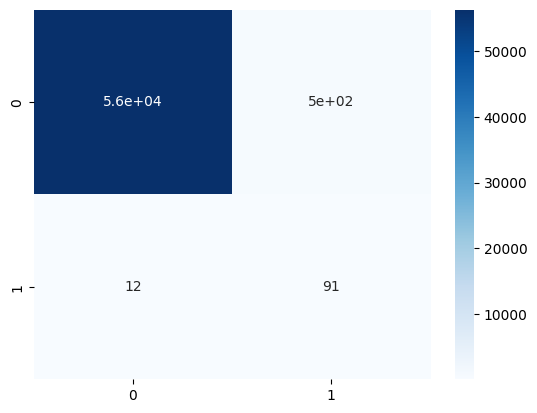

In [42]:
n_runs = 1 #número de execuções
perc_treino = 0.8
batch_size = 16
epochs = 5

recall = []
prec = []
f1 = []

#ponderação por classe
contagem = np.bincount(y)
class_weight = {0: (1/contagem[0]), 1: (1/contagem[1])}
print(class_weight)

for i in range(n_runs):

  #pre-requisito
  model = construirModelo(X.shape[1])

  #a) divide a base aleatoriamente
  x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=perc_treino,
                                                      random_state = random.randint(1, 1000))
  #b) treina
  H = model.fit(
      x_train,
      y_train,
      batch_size= batch_size,
      epochs = epochs,
      callbacks=[PlotLossesKeras()], #plotando gráficos
      validation_split = 0.2,
      class_weight = class_weight #especificar o desbalanceamento
  )

  #c) predição
  y_pred = model.predict(x_test)
  y_true = y_test

  #TODO ajuste o valor de corte adequadamento
  y_pred [y_pred >= 0.5] = 1
  y_pred [y_pred < 0.5]  = 0

  #d) acumula resultados
  recall.append(recall_score(y_true, y_pred, average='binary', pos_label=1))
  prec.append(precision_score(y_true, y_pred, average='binary', pos_label=1))
  f1.append(f1_score(y_true, y_pred, average='binary', pos_label=1))

  matrix = confusion_matrix(y_true, y_pred)
  print("Matriz interação " + str(i) + ":")
  sns.heatmap(matrix, cmap='Blues', annot=True)


#calculando as médias das execuções
recall_media = np.asarray(recall).mean(axis=0)
prec_media = np.asarray(prec).mean(axis=0)
f1_media = np.asarray(f1).mean(axis=0)

#calculando os desvios das execuções
recall_std = np.asarray(recall).std(axis=0)
prec_std = np.asarray(prec).std(axis=0)
f1_std = np.asarray(f1).std(axis=0)

print ("Recall: " + str(recall_media) + " +- " + str(recall_std))
print ("Precisão: " + str(prec_media) + " +- " + str(prec_std))
print ("F1: " + str(f1_media) + " +- " + str(f1_std))



##b) Considerando o desbalanceamento - Gerando amostras sintéticas

Usando a biblioteca imblearn https://imbalanced-learn.org/stable/
- Biblioteca disponibiliza uma série de métodos para under, over ou combinação (sampling)
- Vamos avaliar aqui o SMOTEEN que é combinação de over (SMOTE) e under (ENN) --> https://imbalanced-learn.org/stable/references/combine.html

```
from imblearn.combine import SMOTEENN

sme = SMOTEENN(random_state=random.randint(1, 1000))
x_train, y_train = sme.fit_resample(x_train, y_train)
```

Atenção: dados sintéticos só podem ser gerados sobre os dados de treino.
- Nunca faça esse processo para dados de teste, ou na base inteira de dados

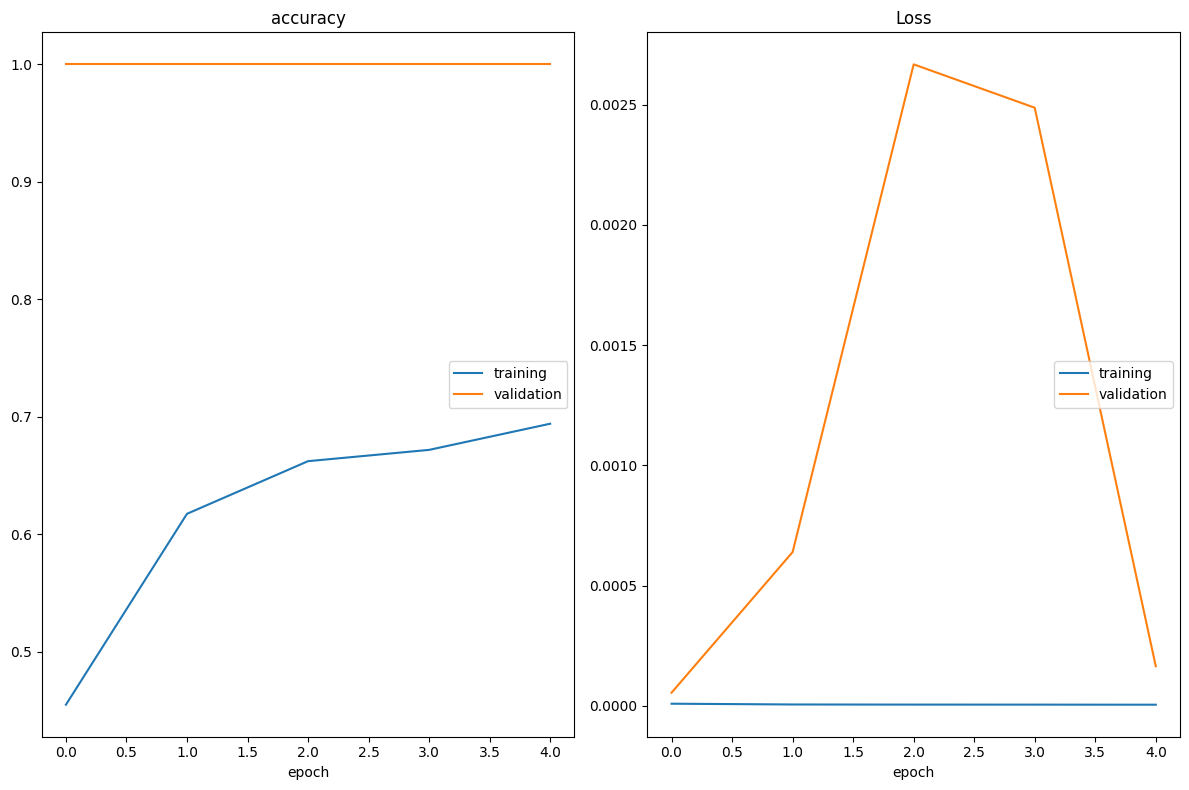

accuracy
	training         	 (min:    0.455, max:    0.694, cur:    0.694)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.003, cur:    0.000)
1781/1781 [==============================] - 4s 2ms/step
Matriz interação 0:
Recall: 1.0 +- 0.0
Precisão: 0.0018776767442351104 +- 0.0
F1: 0.003748315363881402 +- 0.0


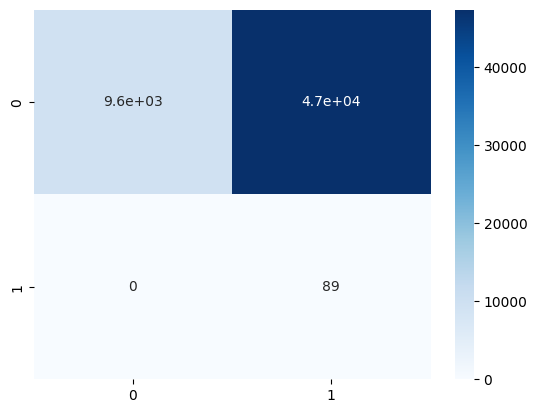

In [43]:
n_runs = 1 #número de execuções
perc_treino = 0.8
batch_size = 16
epochs = 5

recall = []
prec = []
f1 = []

#ponderação por classe
contagem = np.bincount(y)
class_weight = {0: (1/contagem[0]), 1: (1/contagem[1])}
print(class_weight)

for i in range(n_runs):

  #pre-requisito
  model = construirModelo(X.shape[1])

  #a) divide a base aleatoriamente
  x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=perc_treino,
                                                      random_state = random.randint(1, 1000))

  #b) balanceamento
  print(f'Base antes do balanceamento: {np.bincount(y_train)}')
  sme = SMOTEENN(random_state=random.randint(1, 1000))
  x_train, y_train = sme.fit_resample(x_train, y_train)
  print(f'Base após do balanceamento: {np.bincount(y_train)}')

  #b) treina
  H = model.fit(
      x_train,
      y_train,
      batch_size= batch_size,
      epochs = epochs,
      callbacks=[PlotLossesKeras()], #plotando gráficos
      validation_split = 0.2,
      class_weight = class_weight #especificar o desbalanceamento
  )

  #c) predição
  y_pred = model.predict(x_test)
  y_true = y_test

  #TODO ajuste o valor de corte adequadamento
  y_pred [y_pred >= 0.5] = 1
  y_pred [y_pred < 0.5]  = 0

  #d) acumula resultados
  recall.append(recall_score(y_true, y_pred, average='binary', pos_label=1))
  prec.append(precision_score(y_true, y_pred, average='binary', pos_label=1))
  f1.append(f1_score(y_true, y_pred, average='binary', pos_label=1))

  matrix = confusion_matrix(y_true, y_pred)
  print("Matriz interação " + str(i) + ":")
  sns.heatmap(matrix, cmap='Blues', annot=True)


#calculando as médias das execuções
recall_media = np.asarray(recall).mean(axis=0)
prec_media = np.asarray(prec).mean(axis=0)
f1_media = np.asarray(f1).mean(axis=0)

#calculando os desvios das execuções
recall_std = np.asarray(recall).std(axis=0)
prec_std = np.asarray(prec).std(axis=0)
f1_std = np.asarray(f1).std(axis=0)

print ("Recall: " + str(recall_media) + " +- " + str(recall_std))
print ("Precisão: " + str(prec_media) + " +- " + str(prec_std))
print ("F1: " + str(f1_media) + " +- " + str(f1_std))

#Salve o modelo

Ao chegar na melhor opção, opte por salvar o modelo gerado

```
#salvar
model.save('modelo')

#restaurar
modelo_restaurado = tf.keras.models.load_model('modelo')
```

#Etapa 4: Explicabilidade

Usando SHAP
 - !pip install shap

 Docs:
  - https://pypi.org/project/shap/
  - https://shap-lrjball.readthedocs.io/en/latest/api.html

 Alternativas:
  - scikit-explain: https://pypi.org/project/scikit-explain/
  - lime: https://github.com/marcotcr/lime



In [44]:
!pip install shap

In [45]:
#pre-requisito
model = construirModelo(X.shape[1])

#a) divide a base aleatoriamente
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=perc_treino,
                                                      random_state = random.randint(1, 1000))
#b) treina
H = model.fit(
    x_train,
    y_train,
    batch_size= batch_size,
    epochs = epochs*4,
    #callbacks=[PlotLossesKeras()], #plotando gráficos
    validation_split = 0.2,
    class_weight = class_weight #especificar o desbalanceamento
)

#c) predição
y_pred = model.predict(x_test)
y_true = y_test

#TODO ajuste o valor de corte adequadamento
y_pred [y_pred >= 0.5] = 1
y_pred [y_pred < 0.5]  = 0

Epoch 1/20
11393/11393 [==============================] - 39s 3ms/step - loss: 3.9226e-06 - accuracy: 0.6863 - val_loss: 0.2198 - val_accuracy: 0.9994
Epoch 2/20
11393/11393 [==============================] - 39s 3ms/step - loss: 2.0325e-06 - accuracy: 0.9461 - val_loss: 0.0944 - val_accuracy: 0.9991
Epoch 3/20
11393/11393 [==============================] - 39s 3ms/step - loss: 1.5839e-06 - accuracy: 0.9543 - val_loss: 0.0572 - val_accuracy: 0.9970
Epoch 4/20
11393/11393 [==============================] - 37s 3ms/step - loss: 1.5850e-06 - accuracy: 0.9621 - val_loss: 0.0558 - val_accuracy: 0.9981
Epoch 5/20
11393/11393 [==============================] - 38s 3ms/step - loss: 1.5552e-06 - accuracy: 0.9605 - val_loss: 0.2531 - val_accuracy: 0.9724
Epoch 6/20
11393/11393 [==============================] - 39s 3ms/step - loss: 1.5180e-06 - accuracy: 0.9743 - val_loss: 0.2340 - val_accuracy: 0.9745
Epoch 7/20
11393/11393 [==============================] - 38s 3ms/step - loss: 1.4172e-06 - ac

In [46]:
import shap

In [47]:
#cria o modelo de explicabildiade com base nos 1000 primeiros indivíduos
explainer = shap.KernelExplainer(model, x_train[:1000,:])

In [48]:
#calcula explicabilidade prevista para a amostra N = 20, tendo como base 500 individuos
N = 20
shap_values = explainer.shap_values(x_test[N,:], nsamples=500)

In [49]:
#calcula as variáveis que inflenciam a predição baseado na explicabilidade
shap.initjs() #necessário para desenhar o gráfico no jupyter
features = ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10','v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'ammount']
shap.force_plot(explainer.expected_value, shap_values[0],  x_test[N,:], features)

In [50]:
#calcular a explicabilidade de um conjunto de individuos ao mesmo tempo
inicial = 50
final = 100
shap.initjs() #necessário para desenhar o gráfico no jupyter
shap_values50 = explainer.shap_values(x_test[inicial:final,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values50[0], x_test[inicial:final,:], features)

  0%|          | 0/50 [00:00<?, ?it/s]